# Singular Value Decomposition for Background Removal 

### DeepTesla Autopilot Dataset 

#### Mohit Nalavadi 

In this notebook I perform Singular Value Decomposition for the DeepTesla challange dataset. The Objective is to produce predictive steering control using dashcam images from a Tesla and steering values from the CAN data line. My preprocessing step consists of SVD for background removal of the dashboard/hood, glare on the windsheild, and other non-descriptive features in the image that do not change frame-to-frame. These features do not help the predictive power of the model, obscure the view, and only force our model to learn that those features are meaningless, so let's help the model out a little bit. Below I walk through my process. 

In [1]:
import numpy as np 
import pandas as pd 
import os 
import glob 
import scipy
import cv2
import moviepy.editor as moviepy
from sklearn import decomposition
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_dir = os.path.join('..', 'data', 'train')
val_dir = os.path.join('..', 'data', 'validation')

train_vids = glob.glob(train_dir+'\*mkv')
val_vids = glob.glob(val_dir+'\*mkv')

train_labels = glob.glob(train_dir+'\*csv')
val_labels = glob.glob(val_dir+'\*csv')

#display a video 
video = moviepy.VideoFileClip(train_vids[0])
video.subclip(0,5).ipython_display(width=600)

 99%|████████████████████████████████████████████████████████████████████████████▍| 150/151 [00:01<00:00, 81.16it/s]


In [3]:
#and labels 
data = pd.read_csv(train_labels[0])
data.head(5)

ts_micro  frame  wheel
0  1464650070285914      0   -1.0
1  1464650070319247      1   -1.0
2  1464650070352581      2   -1.0
3  1464650070385914      3   -1.0
4  1464650070419247      4   -1.0

In [4]:
#get relative time stamp from video 
dur = video.duration
fps = video.fps

data['rel_time'] = (data['frame'] / fps)
data.head(5)

ts_micro  frame  wheel  rel_time
0  1464650070285914      0   -1.0  0.000000
1  1464650070319247      1   -1.0  0.033333
2  1464650070352581      2   -1.0  0.066667
3  1464650070385914      3   -1.0  0.100000
4  1464650070419247      4   -1.0  0.133333

In [5]:
#check frame labels aligned with real data 

assert np.allclose(video.get_frame(data.iloc[0]['rel_time']),
            video.get_frame(data.iloc[1]['rel_time'])) != True, 'frames not aligned'

In [6]:
#helper functions 

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def plot_three_images(img1, img2, img3, name1=None, name2=None, name3=None, figsize=(12, 7), cmap='gray'): 
    
    plt.figure(figsize=figsize)
    plt.subplot(1, 3, 1);  plt.title(name1)
    plt.imshow(img1, cmap=cmap)


    plt.subplot(1, 3, 2); plt.title(name2)
    plt.imshow(img2, cmap=cmap)
    
    plt.subplot(1, 3, 3); plt.title(name3)
    plt.imshow(img3, cmap=cmap)
    plt.show()
    

def check_frames(clip, frames): 
    num_frames = clip.fps * clip.duration
    desired_dur = frames / clip.fps 
    assert desired_dur <= clip.duration, 'too many frames requested! must be less than {}'.format(num_frames)

def video_to_matrix(clip, frames=-1, scale=100):
    '''create a numpy matrix from the video clip
    
    args: 
    clip : moviepy video object 
    k : num frames 
    scale : (int) resize scale, percentage of original 
    '''
    
    if frames == -1: 
        #all the frames! 
        frames = int(clip.fps * clip.duration)
        
    check_frames(clip, frames)
    image_list = []
    for frame in range(frames):
        time = frame/clip.fps
        img = clip.get_frame(time)
        resized = scipy.misc.imresize(img, scale)
#         flattened = resized.reshape(-1, 3)

        r = resized[:, :, 0].flatten() 
        g = resized[:, :, 1].flatten() 
        b = resized[:, :, 2].flatten()      
        flattened = np.stack([r, g, b], axis=1)

#         flattened = resized[:, :, 0].flatten()
        image_list.append(flattened)
    return np.stack(image_list, axis=1)

In [8]:
#process video to get 2D matrix of [flattened frame x timepoint]
#will later apply background removal via singular value decomposition 

scale = 25  #  scale resolution of image
frames = -1 # all the frames 
dims = (np.array(video.get_frame(0).shape)*scale/100).astype(int)
dims[-1] = 3

% time video_mat = video_to_matrix(video, frames=frames, scale=scale)
# video_mat = video_mat.reshape(dims[0] * dims[1], frames, 3)
print('image dims: {} \nvideo matrix shape {}'.format(dims, video_mat.shape))

Wall time: 23.1 s
image dims: [180 320   3] 
video matrix shape (57600, 1502, 3)


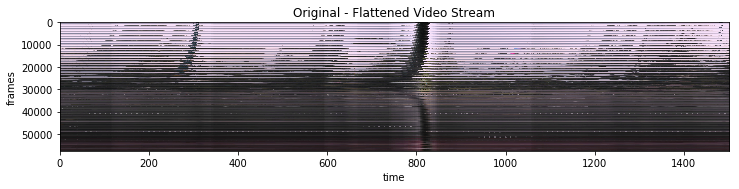

In [9]:
plt.figure(figsize=(12, 12))
plt.title('Original - Flattened Video Stream'); plt.xlabel('time'); plt.ylabel('frames')
plt.imshow(video_mat, aspect=0.005)

In the image above, the horizontal flat lines are the same pixel throughout the video stream. The curves show changes is that pixel over time, the motion of the road. Specifically, I found after some inspection that those large curves are overpasses, overhead road signs, cars, trees (anthing that changes on the road). Flat lines mean no motion, and mathematically, low variance across the video stream. The motion can be viewed as noise in an otherwise steady signal. So noise filtering should allow us to extract the motion of the image.

The purpose of this operation is to remove the dashboard, reflections, and features on the road that are non-descriptive. These features will only make the neural network take more time to converge to a solution during training, and provide no useful additional information. 

# Singular Value Decomposition (SVD)

We can factorize our video matrix using SVD to denoise the matrix. In reality, the noise is what we are interested in, since this is the motion in the video. The denoised matrix will represent what does not change frame-to-frame (dash, reflections etc.). The noise are motion artifacts which we belive to be predictive features for steering wheel control. SVD allows us to approximate our original matrix, and the difference betweent the ground truth and the approximation is the motion in the video stream.

<img src="images/svd.png" width="450" alt="raw" />

$$A  	\sim U\Sigma V^T $$ 

In the equation above, A is our input video matrix, U is a matrix with dimenions $[m, r]$ where m is the single frame from the video and r is the number of non-zero singular values. R is a number we choose, and it is a knob which represents into how many "concpets" we can group our data. A lower value means more data compression, which is a lossier approximation. But since it is the noise (motion) that we are after, and we are subtracting our approximation from ground truth, we actually get a richer output (noise). Essentially, a lower `r` means the denoised matrix, that should not change frame-to-frame, is simpler, and therefore our noise matrix, the motion, is richer in data. 

$\Sigma$ is a diagnoal matrix representing of size $[r, r]$ where the magnitude of any $\Sigma_{ij}$ component is the strength of that component, and $V^t$ is the transpose of a matrix of shape $[r, n]$ where n is the number of frames in the video. The background removal operation is modelled below.

$$A  - U\Sigma V^T  = motion $$ 

We use sklearn's decomposition API to perform the calculation. `decomposition.randomized_svd` has the argument `n_components`, which is a hyperparamter that represents the variable $r$ above. It is the nubmer of "concepts" we are trying to abstractly model. We will arbitrarily set it to one, but it will eventually need to be tuned in a realistic use case. 

In [10]:
def SVD(rgb_matrix, n_components, verbose=False):
    '''perfrom SVD on rgb matrix with r = n_components
    iteravley over each color channel'''
    
    approx = rgb_matrix.copy() #low rank approx
    for i in range(3):    
        U, S, Vt = decomposition.randomized_svd(rgb_matrix[:, :, i], n_components)
        approx[:, :, i] = U @ np.diag(S) @ Vt

    if verbose: 
        print (U.shape, S.shape, Vt.shape)
        print (approx.shape)
    return approx

In [11]:
%time low_rank = SVD(video_mat, 1, True)

(57600, 1) (1,) (1, 1502)
(57600, 1502, 3)
Wall time: 23.9 s


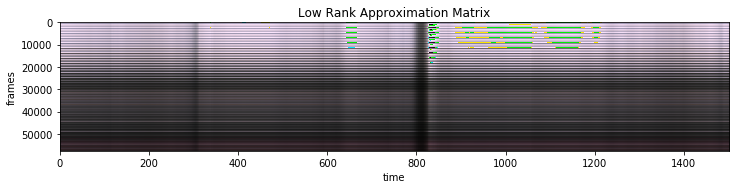

In [12]:
plt.figure(figsize=(12, 12))
plt.title('Low Rank Approximation Matrix');  plt.xlabel('time'); plt.ylabel('frames')
plt.imshow(low_rank, aspect=0.005)

In [13]:
cut = low_rank[115:300, 830:840, :]

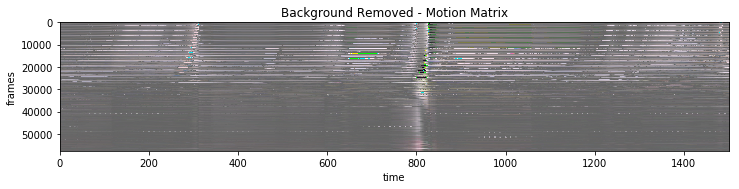

In [14]:
SVD_bg_removed = cv2.absdiff(video_mat, low_rank) + 100

plt.figure(figsize=(12, 12))
plt.title('Background Removed - Motion Matrix');  plt.xlabel('time'); plt.ylabel('frames')
plt.imshow(SVD_bg_removed, aspect=0.005)

As we can see, the video matrix consists mainly of horizontal lines, which mean lack of motion between frames. The dark vertical stripes are where the image gets darker (under an overpass, overhead signs etc). 

Now let's see what the background and motion artifacts look like. 

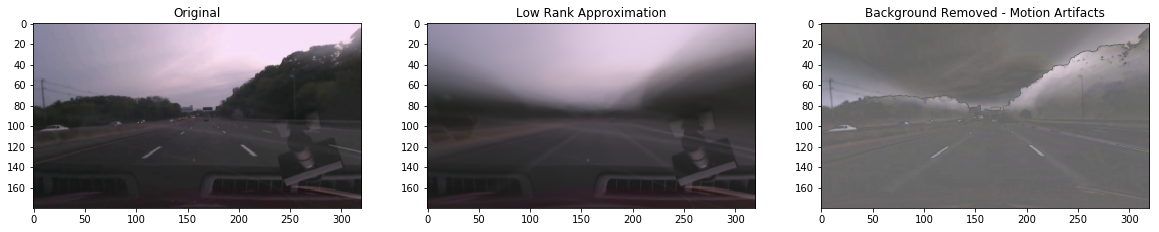

In [15]:
original = video_mat[:, 100].reshape(dims)
background = low_rank[:, 100].reshape(dims)
motion = SVD_bg_removed[:, 100].reshape(dims)

plot_three_images(original, background, motion,
                  'Original', 'Low Rank Approximation', 'Background Removed - Motion Artifacts', (20, 20))

We can also look at the video streams: 

In [16]:
def cvt8bit(arr):
    '''normalize matrix and cvt to 8bit int [0, 255]'''
    mini = np.min(arr)
    maxi = np.max(arr)
    cvt = (arr - mini) / (maxi - mini)
    return (cvt*255).astype('u1')

def make_video(arr, name, fps=fps, dims=dims):
    #use different codec for non-Windows platforms 
    
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(name, fourcc, fps,
                          tuple(dims[:-1][::-1]), 
                          True)

    arr = cvt8bit(arr)
    for i in range(arr.shape[1]):
        img = arr[:, i].reshape(dims)
        out.write(img)
    out.release()
    print ('{} processed'.format(name))

In [99]:
make_video(SVD_bg_removed, 'images/bg_removed_RGB.avi')
make_video(low_rank, 'images/bg_RGB.avi')

images/bg_removed_RGB.avi processed
images/bg_RGB.avi processed


In [100]:
bg_rem_vid = moviepy.VideoFileClip('images/bg_removed_RGB.avi')
bg_rem_vid.subclip(0,10).ipython_display(width=600)

100%|█████████████████████████████████████████████████████████████████████████████▋| 300/301 [00:00<00:00, 1386.05it/s]


In [19]:
bg = moviepy.VideoFileClip('images/bg_RGB.avi')
bg.subclip(0,10).ipython_display(width=600)

100%|█████████████████████████████████████████████████████████████████████████████▋| 300/301 [00:00<00:00, 1016.59it/s]


Great. So we can use SVD to perform background removal on a dashcam image. But for autopilot control, the processing needs to be as close to instantaneous as possible. The several seconds it takes to create a video matrix and perform SVD on it is far too long. One approach could be to perform the SVD once, save that image, and make one step of the image preprocessing pipeline be that image subtraction. Theoretically, we could calculate the SVD every few minutes in the background, or have a few pretrained SVDs for different environment settings, for a real application. But since we only have a few minutes of data total, we can just caculate the value once. 

The low-rank matrix, $A \sim U \Sigma V^T $, is pictured below.  There are brightness streaks throughout the matrix. We need to filter these out, so we will sort the matrix on the column axis and extract a vector of median values. 

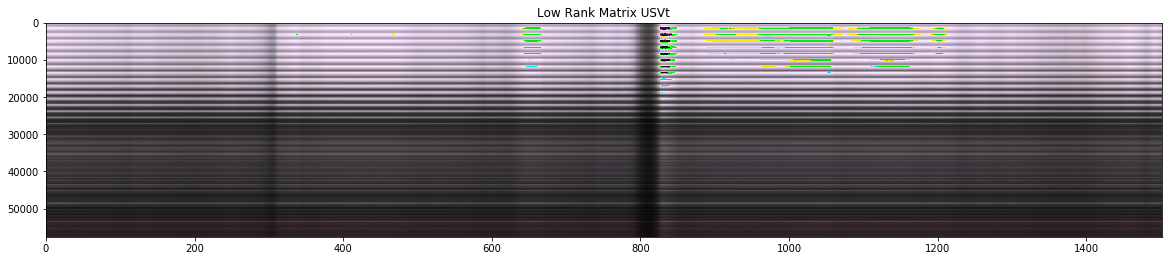

In [17]:
plt.figure(figsize=(20, 20))
plt.title('Low Rank Matrix USVt')
plt.imshow(low_rank, aspect=0.005, cmap='gray')

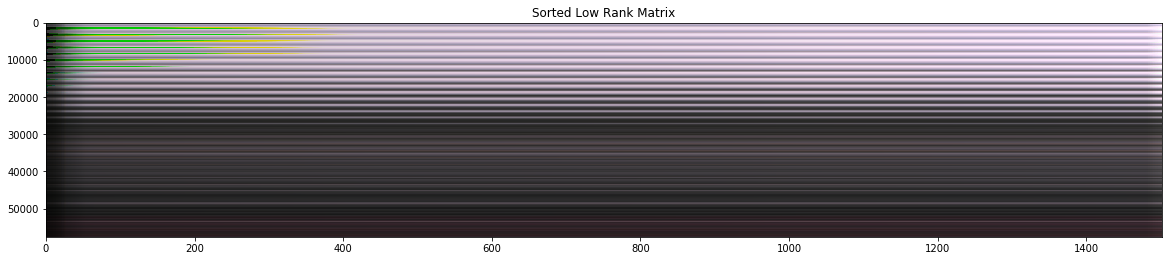

In [18]:
plt.figure(figsize=(20, 20))
plt.title('Sorted Low Rank Matrix')
sorted_low_rank = np.sort(low_rank, axis=1)
plt.imshow(sorted_low_rank, aspect=0.005, cmap='gray')

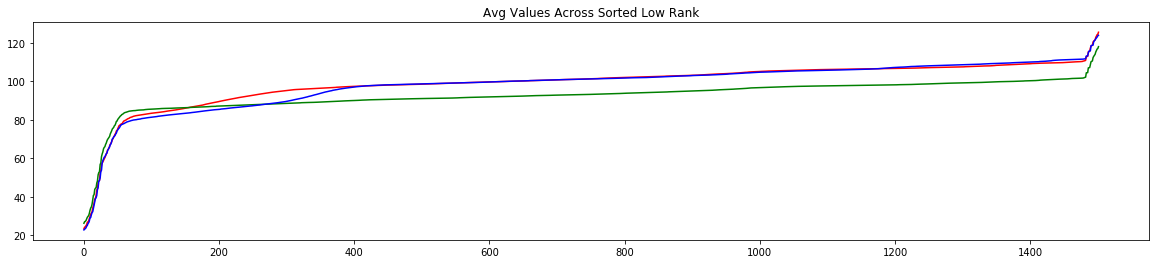

In [19]:
plt.figure(figsize=(20, 4))
plt.title('Avg Values Across Sorted Low Rank')
means = np.mean(sorted_low_rank , axis=0)
plt.plot(means[:, 0], 'r', means[:,1], 'g', means[:,2], 'b')

Avoiding asymptotes, we can safely take the mean from frames 600 - 1000. 

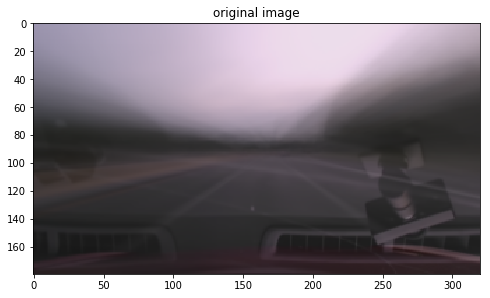

In [20]:
avg_low_rank = np.mean(sorted_low_rank[:, 600:1000, :], axis=1).astype('u1')
plt.figure(figsize=(8, 8))
plt.title('original image')
plt.imshow(avg_low_rank.reshape(dims), cmap='gray')

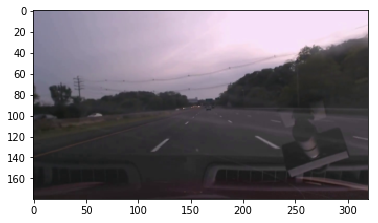

Now we can test out what a frame with the full SVD pipeline applied to it would look like. 

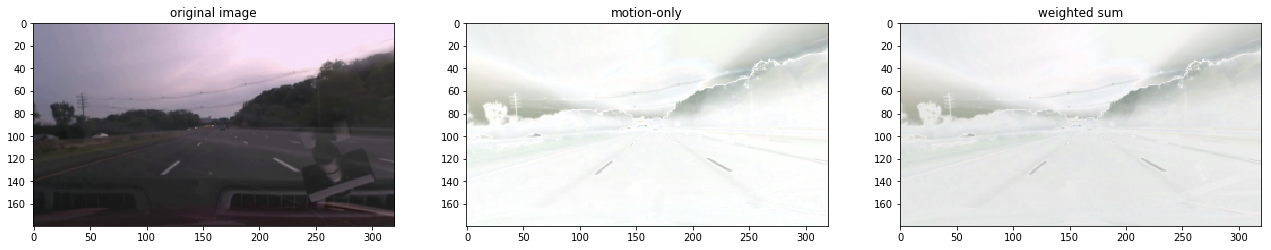

In [63]:
test_img = scipy.misc.imresize(video.get_frame(109), 25)
bg = avg_low_rank.reshape(dims)
diff = 255-cv2.absdiff(test_img, bg)
out = cv2.addWeighted(diff, 0.9, test_img, 0.1, 1)

plot_three_images(test_img, diff, out,
                  'original image', 'motion-only', 'weighted sum',
                  figsize=(22, 22))

This looks good. In addition, we can crop out the sky. So to recap the whole image processing pipeline: 
   
**Preprocessing (done before driving)**

The purpose here is to create the low-rank approximations for background removal. For a self-driving vehicle to accomplish this is deployment, this approximation matrix would need to be calculated every few seconds. Since we are working with prerecorded data, and without a supercomputer, these will be precalculated. But note that this step is analagous to a proposed matrix update. 

- With prerecorded data, read in video clip 

- Convert clip to matrix, where rows = pixel and columns = time 

- Perform Singular Value Decomposition for background removal on each image channel 

- Get average of low rank matrix along pixel axis and reduce reduce to low rank to single frame

** Image Processing during driving **

- Read in dash cam image 

- Subtract Low Rank Average computed beforehand to get motion-only frame

- Create Weighted Average of original frame and motion-only frame 

- Crop out sky 

- Normalize values

- Feed into Conv. Net


In [90]:
def preprocessing(clip_name):
    '''preprocessing step for video clip
    
    args: 
    clip : (str) video file name'''
    
    clip = moviepy.VideoFileClip(clip_name)
    dims = list((np.array(clip.get_frame(1).shape)*25/100).astype(int)) #output image dims 
    dims[-1] = 3
    
    #create video matrix, perform SVD, get low_rank image 
    video_matrix = video_to_matrix(clip, frames=-1, scale=25)
    low_rank_approx = SVD(video_matrix, n_components=1, verbose=False)
    low_rank_sort = np.sort(low_rank_approx, axis=1)
    
    #clip the sorted low rank matrix and get the average
    low_clip = int(low_rank_sort.shape[1]*0.33)
    high_clip = int(low_rank_sort.shape[1]*0.66)
    avg_low_rank = np.mean(low_rank_sort[:, low_clip:high_clip, :], axis=1)
    avg_low_rank = avg_low_rank.reshape(dims)
    
    #save
    outname = '..'+clip_name.split('.')[-2] + '_low_rank.png'
    scipy.misc.imsave(outname, avg_low_rank)
    print ('{} processed!'.format(clip_name))

In [91]:
for im in tqdm(val_vids):
    preprocessing(im)

A Jupyter Widget

..\data\validation\epoch08_front.mkv processed!
..\data\validation\epoch09_front.mkv processed!
..\data\validation\epoch10_front.mkv processed!



In [92]:
for im in tqdm(train_vids):
    preprocessing(im)

A Jupyter Widget

..\data\train\epoch01_front.mkv processed!
..\data\train\epoch02_front.mkv processed!
..\data\train\epoch03_front.mkv processed!
..\data\train\epoch04_front.mkv processed!
..\data\train\epoch05_front.mkv processed!
..\data\train\epoch06_front.mkv processed!
..\data\train\epoch07_front.mkv processed!



Let's take a look at the different matrices 

TRAIN


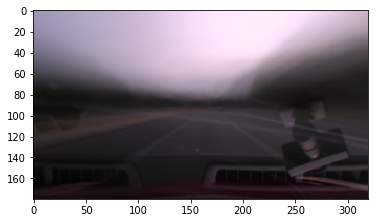

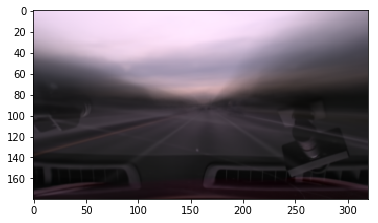

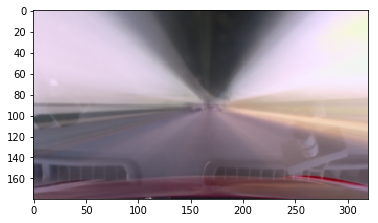

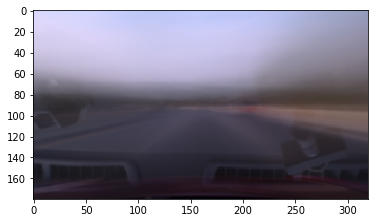

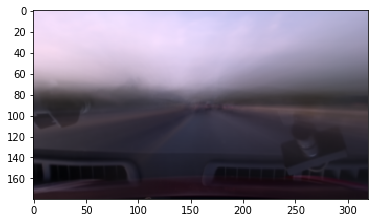

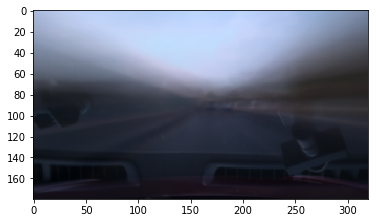

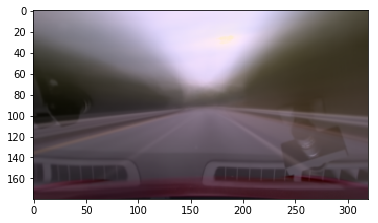

VALDIATION


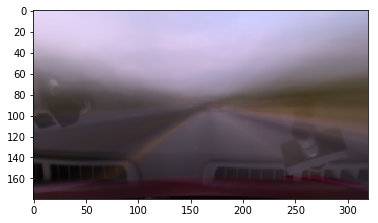

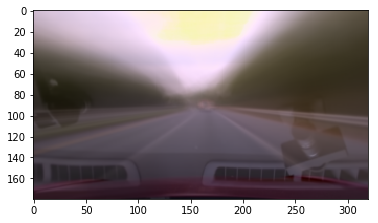

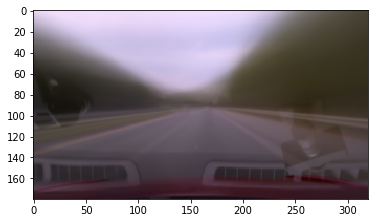

In [94]:
print ('TRAIN')
train_lowrank = glob.glob(train_dir+'\*png')
for im in train_lowrank: 
    plt.imshow(scipy.misc.imread(im), cmap='gray'); plt.show()
    
print ('VALDIATION')
val_lowrank = glob.glob(val_dir+'\*png')
for im in val_lowrank: 
    plt.imshow(scipy.misc.imread(im), cmap='gray'); plt.show()
